### Time to get you hands dirty! A noisy detector.

Three telescopes are monitoring the same astronomical event. Their time-series output is provided  at `solutions/noisydetector.npy`. These could be the outputs of three photometry CCD cameras we still need to calibrate, or the strain channel from a gravitational-wave detectors. 

We're looking for some physics in noisy data, assuming we have multiple observations.

Our detectors measure the following outputs, which to me just looks like a pile of junk. Someone really forgot to read the telescope manual here!

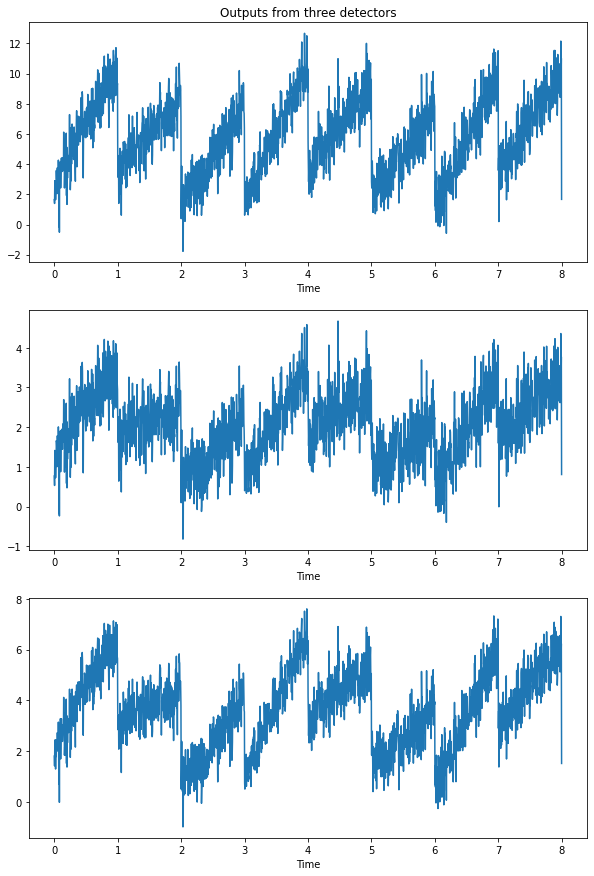

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/Users/giuliamariaborro/box/reps/astrostatistics_bicocca_2022/solutions/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');

In a realistic scenario, those jumps will have a physical meaning. Say for a satellite we need to [re-point the radio antennas](https://arxiv.org/abs/1907.04747) to send data down to Earth, and the whole thing shakes a bit. Or say the [the Starlink satellites](https://www.science.org/content/article/starlink-already-threatens-optical-astronomy-now-radio-astronomers-are-worried) are polluting your telescope data (I'm making this up, I don't really know what kind of data contamination they would cause!).



***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.

(When detecting a signal, state-of-the-art gravitational-wave analysis make use of another tecnique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) which, unfortunately, we do not have time to cover here. But PCA is used to classify instrumental artifacts, see e.g. [Powell et al 2005](https://arxiv.org/abs/1505.01299)).

----------
## My implementation

In [2]:
import scipy
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import emcee
import corner

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15

In [3]:
X.shape

(2000, 3)

In [4]:
X.T

array([[ 1.64846254,  1.39509665,  2.90309446, ...,  9.55032295,
        11.01366437,  1.66638559],
       [ 0.77179892,  0.5330968 ,  1.41468844, ...,  3.12512086,
         3.77033436,  0.80869969],
       [ 1.81395692,  1.42738704,  2.29865643, ...,  5.75843618,
         6.23327213,  1.522431  ]])

Text(0.5, 0, 'time')

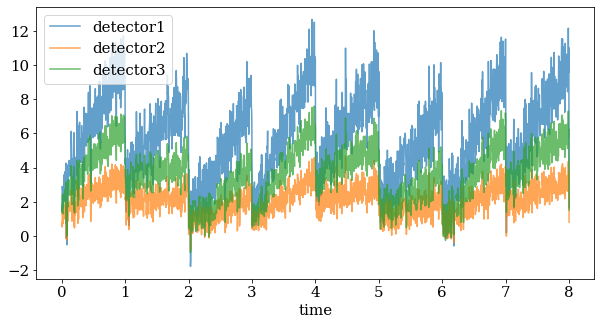

In [24]:
time = np.linspace(0, 8, len(X))

for i in range(0, len(X.T)): 
    plt.plot(time, X.T[i], alpha = 0.7, label='detector'+str(i+1))
plt.legend()
plt.xlabel('time')

### PCA

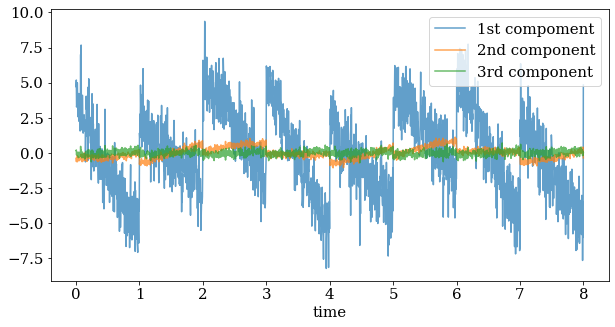

In [103]:
# do PCA
n_components = 3
pca = PCA(n_components=n_components)                
eigenvalues = pca.fit_transform(X)               # 2000x3 components
mean = pca.mean_                                 # 3 mean values
eigenvectors = pca.components_                   # 3x3 matrix component
# print(eigenvalues.shape, '\n', eigenvectors.shape)


# plot the components
plt.plot(time, eigenvalues[:,0], alpha=0.7, label='1st compoment')
plt.plot(time, eigenvalues[:,1], alpha=0.7, label='2nd component')
plt.plot(time, eigenvalues[:,2], alpha=0.7, label='3rd component')


plt.xlabel('time')
plt.legend()

Let's see each component better

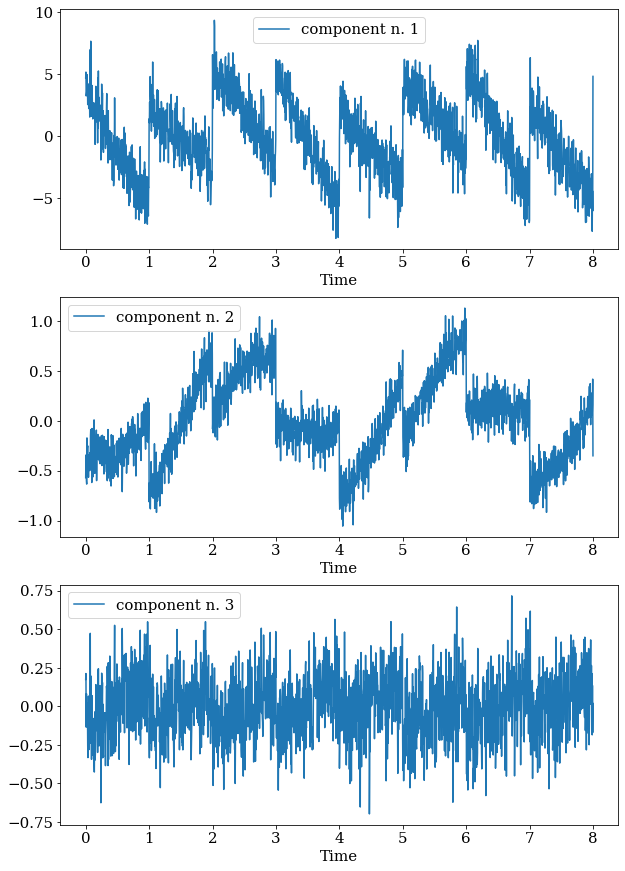

In [7]:
fig, axs = plt.subplots(nrows = 3, figsize=(10,15))
for i, ax in zip(np.arange(0, n_components), axs):
    ax.plot(time, eigenvalues[:,i], label='component n. '+str(i+1))
    ax.set_xlabel('Time')
    ax.legend()

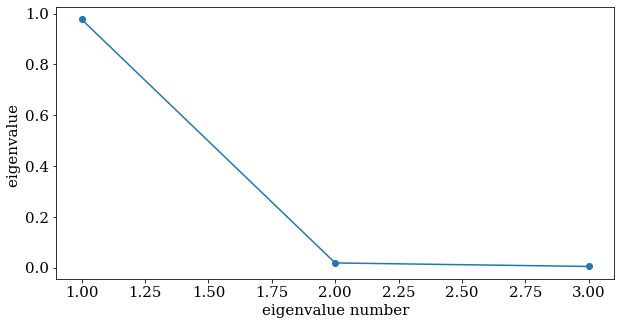

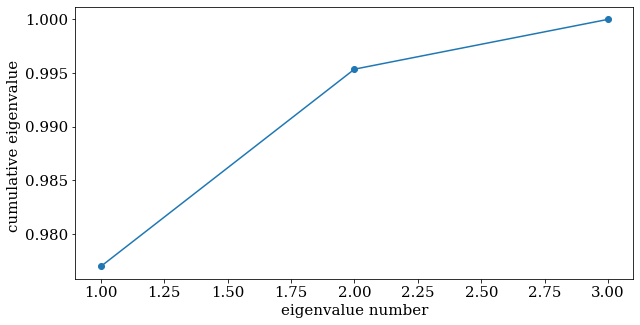

In [8]:
# scree plots
evals = pca.explained_variance_ratio_


plt.plot(range(1, n_components+1), evals)
plt.scatter(range(1, n_components+1), evals)
plt.xlabel("eigenvalue number")
plt.ylabel("eigenvalue ")

plt.show()
plt.clf()


plt.plot(range(1,n_components+1), evals.cumsum())
plt.scatter(range(1,n_components+1), evals.cumsum())
plt.xlabel("eigenvalue number")
plt.ylabel("cumulative eigenvalue ");


### ICA

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


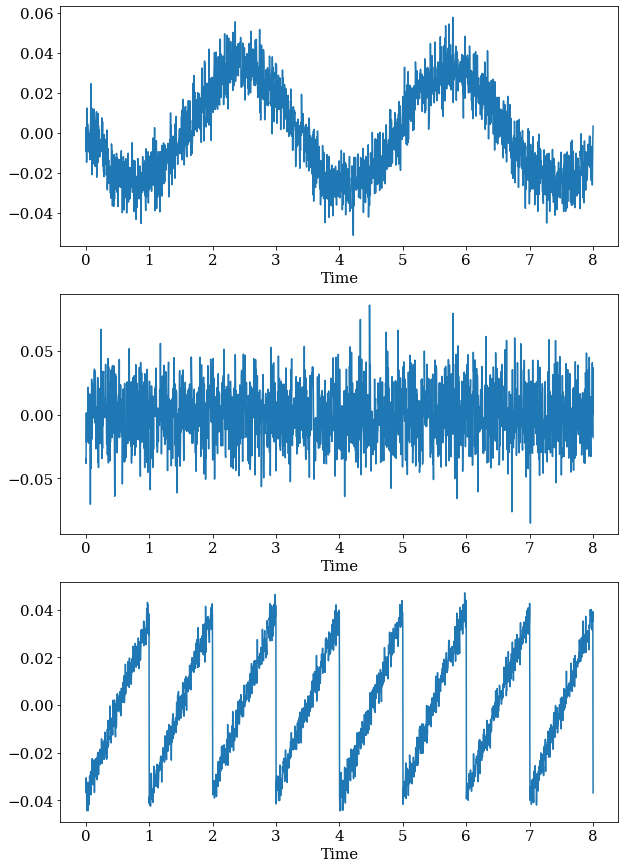

In [8]:
ica = FastICA(n_components=n_components, random_state=8)
eigenvalues = ica.fit_transform(X)

fig, axs = plt.subplots(nrows = 3, figsize=(10,15))
for i, ax in zip(np.arange(0, n_components), axs):
    ax.plot(time, eigenvalues[:,i])
    ax.set_xlabel('Time')

#### Period measure

Do a quick model to measure the period

In [9]:
# take only the sinusoidal signal
s = 0
s_cleaned = eigenvalues[:,s]  

In [10]:
# Model
def sinusoidal(time, A, T, phi):
    #A, T, phi = par
    return (A * np.sin(2 * np.pi * time / T + phi))

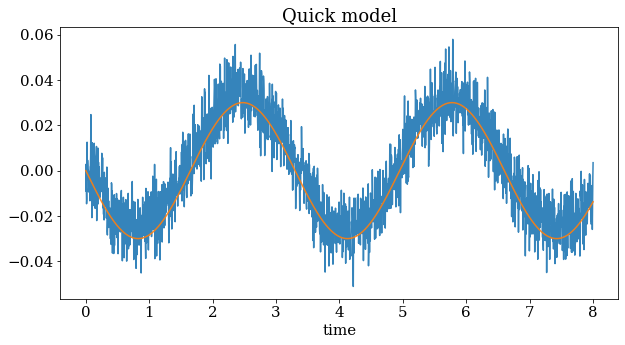

In [11]:
''' NOTICE: s must be changed 0,1 or 2 manually 
according to the position of the sinusoidal signal
'''

# quick inizialization
A0 = 0.03                           #amplitude
T0 = 3.3                            #period
F0 = np.pi                          #phase

par = np.array([A0, T0, F0])

quick_model = sinusoidal(time, A0, T0, F0)

plt.plot(time, s_cleaned, alpha=0.9)
plt.plot(time, quick_model, alpha=0.9)  
plt.xlabel('time')
plt.title('Quick model');

The model seems ok!

Now we check if the residuals are distributed along a Gaussian. If so, we can use a least square fit method.

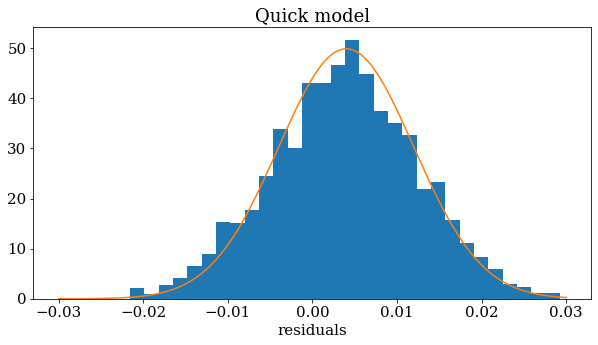

In [108]:
res = s_cleaned - sinusoidal(time, A0, T0, F0)
plt.hist(res, bins= 30, density=True);

mu = 0.004
sigma = 0.008

xgrid = np.linspace(-0.03, 0.03, 500)
quick_gaussian = scipy.stats.norm.pdf(xgrid, mu, sigma)
plt.plot(xgrid, quick_gaussian)
plt.xlabel('residuals')
plt.title('Quick model');

### Curve fit

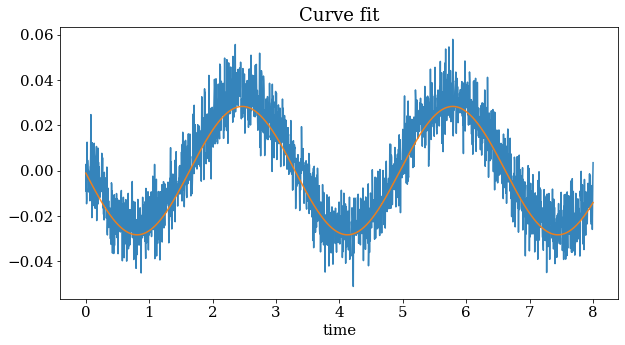

In [110]:
parameters, covariance = scipy.optimize.curve_fit(sinusoidal, time, s_cleaned, ([A0, T0, F0]))

s_model = sinusoidal(time, *parameters)

plt.plot(time, s_cleaned, alpha=0.9)
plt.plot(time, s_model, alpha=0.9)  
plt.xlabel('time')
plt.title('Curve fit');

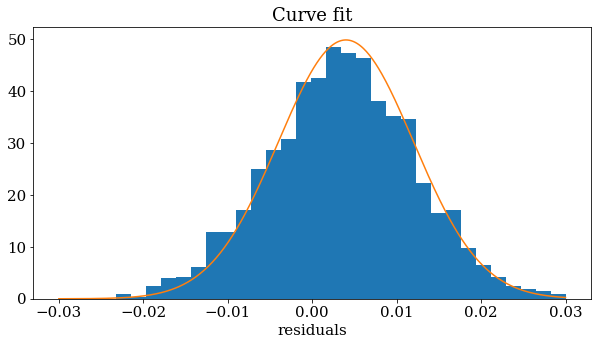

In [111]:
# check res with the actual model to see if model is right

res = s_cleaned - sinusoidal(time, *parameters)
plt.hist(res, bins= 30, density=True);
plt.plot(xgrid, quick_gaussian)
plt.xlabel('residuals')
plt.title('Curve fit');

See if residuals are Gaussian using also KS test:

In [112]:
scipy.stats.kstest(res, "norm", args=[np.mean(res), np.std(res)])

KstestResult(statistic=0.011379523420511628, pvalue=0.9553306033626225)

In [16]:
Tfit = parameters[1]
Terr = np.sqrt(np.diag(covariance))[1]
print('T from the fit: ', Tfit, '+-', Terr)

T from the fit:  3.3180148573483206 +- 0.008228300986855609


In [17]:
Ttrue = 3.3
(Tfit-Ttrue)/Terr

2.1893775370029354

### MCMC

In [18]:
# se non funzia inserire qui i dati
def logLikelihood(par):
    A, T, phi = par
    yfit =  sinusoidal(time, A, T, phi)
    return -0.5*np.sum((s_cleaned-yfit)**2)/(sigma**2)


def logPrior(par):
    A, T, F = par
    if 0 < A < 1 and 0 < T < 6 and 0 < F < 2*np.pi:
        return 0.0 
    else: 
        return -np.inf

def logPosterior(par):   
#def logPosterior(par, data):
 #   return logPrior(par) + logLikelihood(par, data)
    return logPrior(par) + logLikelihood(par)

In [19]:
ndim = 3         # number of parameters in the model
nwalkers = 20    # number of walkers
nsteps = 8000    # steps for each walker


# initialize parameters 
P0 = par + np.random.random((nwalkers, ndim))/1000  
print(P0.shape, '\n',P0)

(20, 3) 
 [[0.03054417 3.30068817 3.14243203]
 [0.03047289 3.30013872 3.14234654]
 [0.03067986 3.30052087 3.14222225]
 [0.03098977 3.30033116 3.14187425]
 [0.03026822 3.30017913 3.14209849]
 [0.03055858 3.30099528 3.14189004]
 [0.03076091 3.30069182 3.1424254 ]
 [0.03044667 3.30077309 3.14209436]
 [0.03036248 3.30002583 3.14210194]
 [0.03004595 3.30028578 3.14215749]
 [0.03081673 3.30032834 3.14241025]
 [0.03074119 3.30091597 3.14220533]
 [0.03005523 3.30039493 3.14251275]
 [0.03095132 3.30022675 3.14238308]
 [0.03039749 3.30071143 3.14238089]
 [0.03039534 3.30007188 3.14173676]
 [0.03048006 3.30025607 3.14220219]
 [0.03074535 3.30070403 3.14193309]
 [0.03074237 3.30091672 3.14195223]
 [0.03048458 3.30005601 3.14240016]]


In [20]:
#MCMC 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)  
result = sampler.run_mcmc(P0, nsteps)   
print(result)  

State([[0.02821815 3.32549773 3.19568853]
 [0.02811472 3.32760287 3.20492519]
 [0.02820583 3.3130666  3.16964003]
 [0.02840918 3.31220383 3.16681319]
 [0.028431   3.31645344 3.18148017]
 [0.02791985 3.32658312 3.20588417]
 [0.02822042 3.3081124  3.16496151]
 [0.02848179 3.31510077 3.18375501]
 [0.02812523 3.31760078 3.19318327]
 [0.02858227 3.3192034  3.18036245]
 [0.02848196 3.3152011  3.16953651]
 [0.02818844 3.31783004 3.17284583]
 [0.02840557 3.31838538 3.17447363]
 [0.02790679 3.32307788 3.19280921]
 [0.02807813 3.32460905 3.19446908]
 [0.02810236 3.30703326 3.14633077]
 [0.02823276 3.32217546 3.18100927]
 [0.02817691 3.31708942 3.17894485]
 [0.02850536 3.32602142 3.19830168]
 [0.02854313 3.32349939 3.17070713]], log_prob=[-1354.25828156 -1354.83918116 -1354.05915085 -1354.04259935
 -1353.94000373 -1355.73298044 -1355.00858959 -1354.5711938
 -1355.15239277 -1354.2996014  -1354.06500808 -1354.14112823
 -1354.01197866 -1355.21586098 -1354.48708594 -1355.8863436
 -1354.33278439 -1353

(8000, 20, 3)


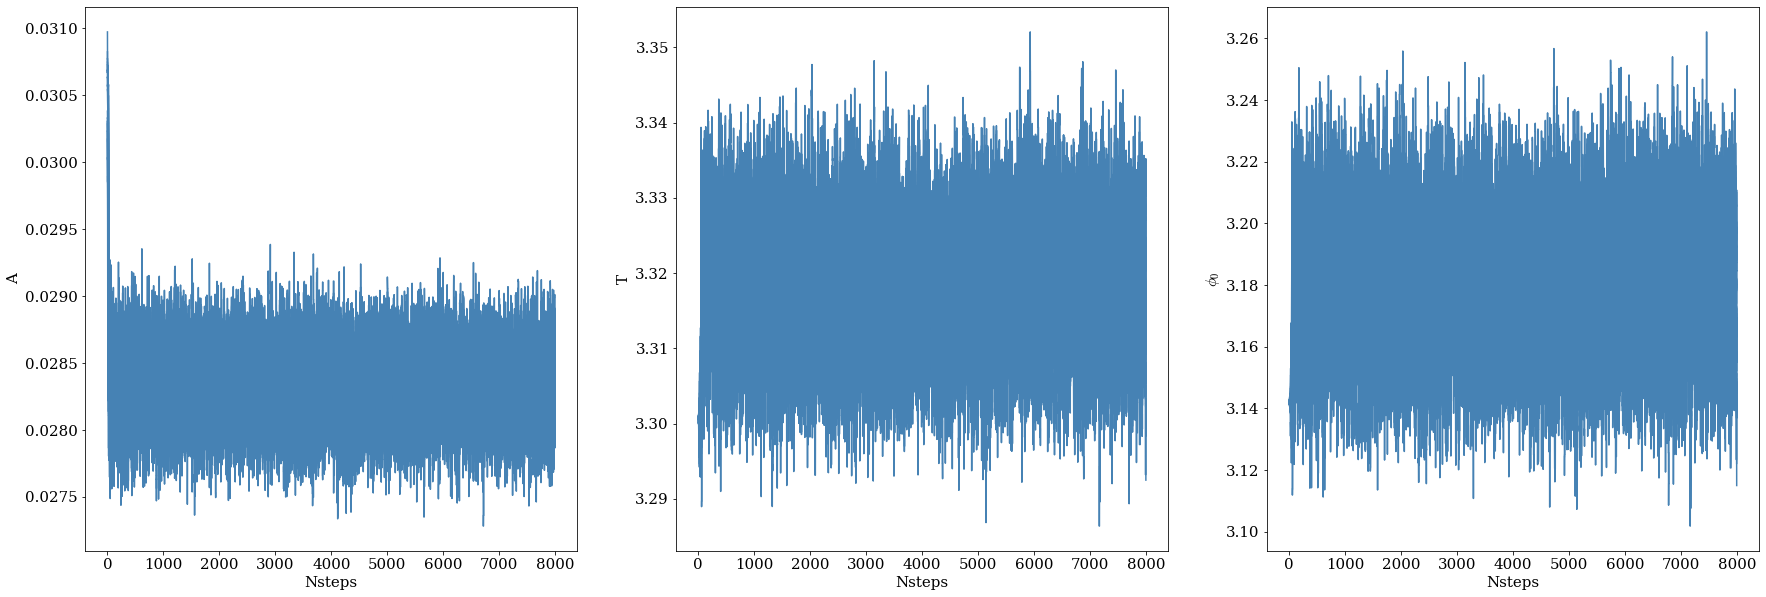

In [76]:
samples = sampler.get_chain()
print(samples.shape)


label = ['A', 'T', r'$\phi_0$']
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
axs = [ax[0], ax[1], ax[2]]

for a,i in zip(axs, range(len(X))):
    
    a.plot(samples[:, :, i], color='steelblue')
    a.set_ylabel(label[i])
    a.set_xlabel('Nsteps')


In [77]:
# autocorrelation time
tau = sampler.get_autocorr_time()
print(tau)


# autocorrelation length and the burnin
burnin = int(max(tau)*2)           
al = int(max(tau))               

# THIN THE SAMPLE
thinsamples = sampler.get_chain(discard = burnin, thin = al)   
print(thinsamples.shape)  


# flatten the samples taken for each walker in a single sample 
flatsamples = sampler.get_chain(discard = burnin, thin = al, flat=True)
print(flatsamples.shape)   # if too low increase nsteps

[36.91456907 38.58022594 38.03008664]
(208, 20, 3)
(4160, 3)


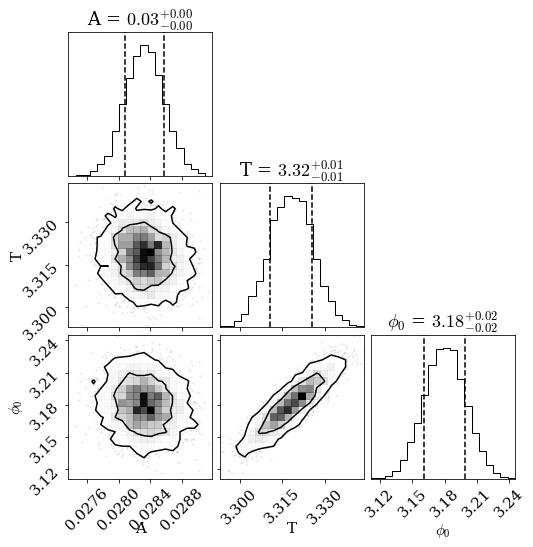

In [78]:
# Posterior
figure = corner.corner(flatsamples, labels=label, 
                       levels = [0.68, 0.95], quantiles=[0.16, 0.84],
                       show_titles=True)

In [79]:
# estimate parameters with the median and 90% credible region

estimators = []
quantile95 = []
quantile05 = []

for i in range(ndim):
    
    # save the values in lists  
    estimators.append(np.median(flatsamples[:, i]))
    quantile95.append(np.quantile(flatsamples[:, i], 0.95)) 
    quantile05.append(np.quantile(flatsamples[:, i], 0.05)) 
     
    # upper and lower labels for 90% credible region
    upper_bound = quantile95[i]-par[i]        
    lower_bound = par[i]-quantile05[i]

    print(label[i], '=', str(round(par[i],4)),'+', 
          str(round(upper_bound,4)), '-', str(round(lower_bound,4)))

A = 0.03 + -0.0013 - 0.0021
T = 3.3 + 0.0305 - -0.0055
$\phi_0$ = 3.1416 + 0.0703 - -0.0066


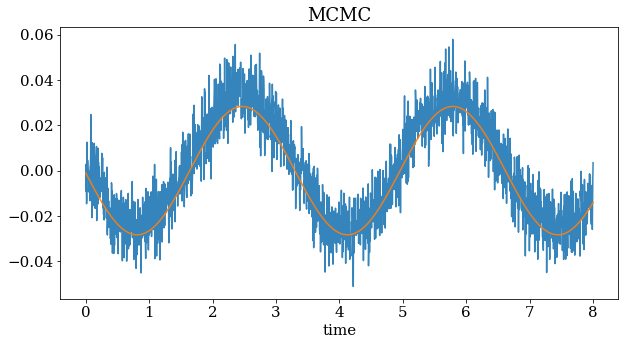

In [80]:
mcmc_model = sinusoidal(time, *estimators)

plt.plot(time, s_cleaned, alpha=0.9)
plt.plot(time, mcmc_model, alpha=0.9) 
plt.xlabel('time')
plt.title('MCMC');

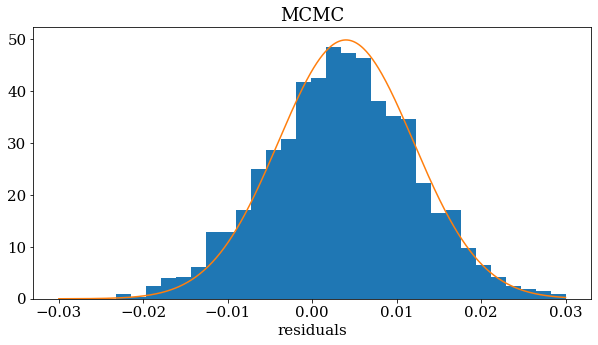

In [84]:
# check res with the actual model to see if model is right

res = s_cleaned - mcmc_model
plt.hist(res, bins= 30, density=True);
plt.plot(xgrid, quick_gaussian)
plt.xlabel('residuals')
plt.title('MCMC');

In [107]:
scipy.stats.kstest(res, "norm", args=[np.mean(res), np.std(res)])

KstestResult(statistic=0.011379523420511628, pvalue=0.9553306033626225)